## Plotting ISCO sample inventory over Ranch Brook and Mill River winter 2024 discharge

### Downlaoded provisional daily mean discharge (cfs) from USGS for Ranch Brook (Wade analog) and Mill River (Hungerford analog) from 12-31-23 to 04-17-24

## TO DO:

- Fix time zone accounting (it's not right, currently 06.07.2024 MED)

In [116]:
setwd("/home/millieginty/OneDrive/git-repos/EMMA/")

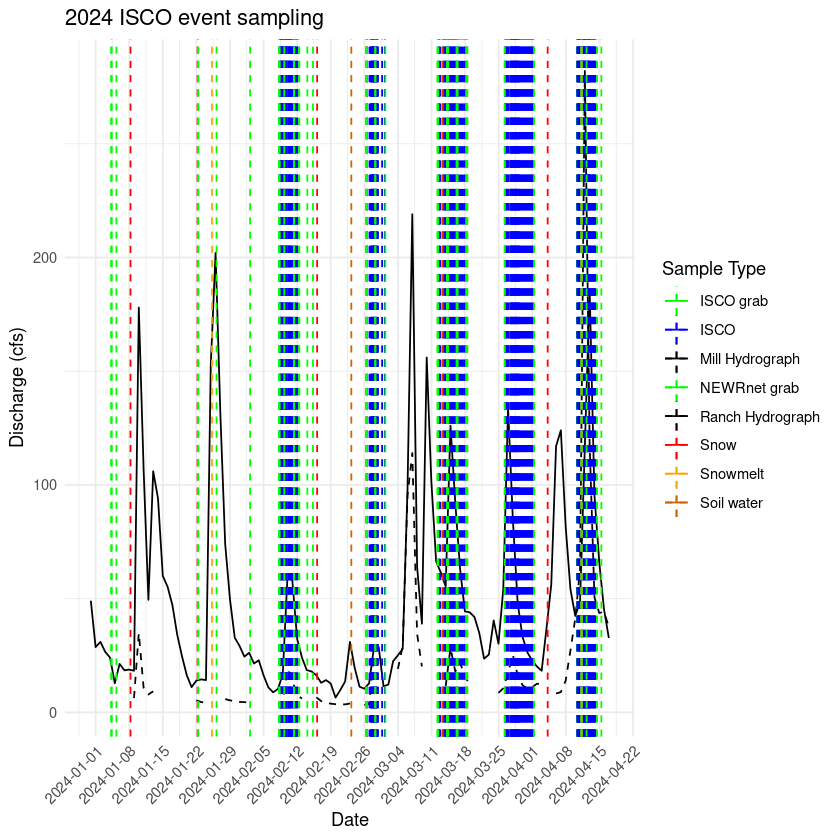

In [130]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data
library(readxl)

###################
# SET DIRECTORIES #
###################

input_dir <- "data/"
output_dir <- "isco_metadata/"

################
# READ IN DATA #
################

# read in the streamwater ISCO metadata
MetadataISCO <- read_excel(file.path(input_dir, "Stream_Data_2024.xlsx"), sheet = 1, 
                           col_types = c("text", "text", "date", "date", "text", "text", "text"))

# Combine Date, Time, and Time zone columns into a single Datetime column
MetadataISCO <- MetadataISCO %>%
  mutate(Datetime = ymd_hms(paste(Date, format(Time, "%H:%M:%S"), "Time Zone")))

# read in the (provisional) NEWRnet grab sample metadata
MetadataGrab <- read_excel(file.path(input_dir, "Newrnet_Field_MEDupdate_06.06.24.xlsx"), sheet = 1, 
                           col_types = c("text", "text", "text", "date", "date", 
                                         "text", "text", "text", "text", "text", "text", "text",
                                        "text", "text", "text", "text", "text", "date",
                                        "text", "text", "text", "text", "text"))

# Combine Date, Time, into a single Datetime column
MetadataGrab <- MetadataGrab %>%
  mutate(Datetime = ymd_hms(paste(Date, format(`Water Sampling Time`, "%H:%M:%S"))))

# read in provisional USGS q data for Ranch Brook and Mill River
Ranch_Q <- read.csv(file.path(input_dir, "usgs_provisional_winter2024_discharge_ranch.csv"), 
                    stringsAsFactors = FALSE)

Mill_Q <- read.csv(file.path(input_dir, "usgs_provisional_winter2024_discharge_mill.csv"),
                   stringsAsFactors = FALSE)

####################
# CLEAN THE DATA  #
####################

# Convert the date column to a POSIXct object
Ranch_Q$Date <- as.POSIXct(Ranch_Q$Date, format="%Y-%m-%d")

Mill_Q$Date <- as.POSIXct(Mill_Q$Date, format="%Y-%m-%d")

# Convert USGS ice values to NA (just for Ranch, Mill doesn't have ice entries)
Ranch_Q$mean_discharge_cfs[Ranch_Q$mean_discharge_cfs == "Ice"] <- NA
Ranch_Q$mean_discharge_cfs <- as.numeric(Ranch_Q$mean_discharge_cfs)

#######################
# PLOT THE HYDROGRAPH #
#######################

# include vertical lines for when we have ISCO samples
hydrograph_plot_ISCO_with_lines <- ggplot() +
  geom_line(data = Mill_Q, aes(x = Date, y = mean_discharge_cfs, color = "Mill"), linetype = "solid") +
  geom_line(data = Ranch_Q, aes(x = Date, y = mean_discharge_cfs, color = "Ranch"), linetype = "dashed") +
  geom_vline(data = MetadataISCO, aes(xintercept = Datetime, color = Type), linetype = "dashed") +
  geom_vline(data = MetadataGrab, aes(xintercept = Datetime, color = "NEWRnet"), linetype = "dashed") +
  theme_minimal() +
  labs(title = "2024 ISCO event sampling",
       x = "Date",
       y = "Discharge (cfs)",
       color = "Sample Type") +
  scale_x_datetime(date_labels = "%Y-%m-%d", date_breaks = "1 week") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(strip.text = element_text(size = 8)) +
  scale_color_manual(
    values = c("Mill" = "black", "Ranch" = "black", "Isco" = "blue", "Snow" = "red", 
               "Snowmelt lysimeter" = "orange", "Soil water lysimeter" = "darkorange3", 
               "Grab" = "green", "NEWRnet" = "green"),
    labels = c("Mill" = "Mill Hydrograph", "Ranch" = "Ranch Hydrograph", "Isco" = "ISCO", 
               "Snow" = "Snow", "Snowmelt lysimeter" = "Snowmelt", 
               "Soil water lysimeter" = "Soil water", "Grab" = "ISCO grab", "NEWRnet" = "NEWRnet grab")
  )

# Save the plot with specified dimensions
ggsave(file.path(output_dir, "hydrograph_plot_ISCO_with_lines.png"), plot = hydrograph_plot_ISCO_with_lines, width = 10, height = 6, dpi = 300)

# Print the modified plot
print(hydrograph_plot_ISCO_with_lines)